<a href="https://colab.research.google.com/github/Ash100/Documents/blob/main/PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    ProLIF (https://github.com/chemosim-lab/ProLIF)
6.    Numpy (https://numpy.org/)
7.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

In [ ]:
#@title **Install Conda Colab**
#@markdown It will restart the kernel (session), don't worry.
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...


In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
import subprocess
import sys
subprocess.run("rm -rf /usr/local/conda-meta/pinned", shell=True)
subprocess.run("mamba install -c conda-forge ambertools -y", shell=True)
import pytraj as pt
subprocess.run("pip -q install py3Dmol", shell=True)
subprocess.run("pip install git+https://github.com/pablo-arantes/biopandas", shell=True)
subprocess.run("mamba install openmm=7.7.0 pdbfixer -y", shell=True)
subprocess.run("mamba install openmmforcefields -c conda-forge -y", shell=True)
subprocess.run("pip install prolif==1.1.0", shell=True)
subprocess.run("mamba install -c conda-forge openbabel -y", shell=True)
subprocess.run("mamba install -c conda-forge parmed -y", shell=True)
subprocess.run("pip install --upgrade MDAnalysis==2.4.2", shell=True)
subprocess.run("pip install numpy==1.23.5", shell=True)
subprocess.run("pip install --upgrade pluggy", shell=True)

#load dependencies
from openmm import app, unit
from openmm.app import HBonds, NoCutoff, PDBFile
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from openff.toolkit.utils import get_data_file_path
import parmed as pmd
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
# !wget  https://raw.githubusercontent.com/openforcefield/openff-forcefields/master/openforcefields/offxml/openff_unconstrained-2.0.0.offxml

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

---
---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**Important**: Make sure the PDB file points to the correct pathway. If necessary, correct the pathway and re-upload the files. We will merge the receptor and ligand structure objects to form the complex. Note that the coordinates of protein and ligand are determined by the PDB file, and they should be consistent with the ligand being positioned in the binding pocket.

Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.

**Please, don't use spaces in the files and folders names, i.e., protein_inpupt.pdb, MyDrive/protein_ligand and so on.**

In [ ]:
#@title **Please, provide the necessary input files below**:
#@markdown **Important:** The protonation of your ligand is crucial for the correct parameterization of the molecule.
# %%capture
import rdkit
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolTransforms
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdForceFieldHelpers
from IPython.display import SVG
import ipywidgets as widgets
import rdkit
from rdkit.Chem.Draw import IPythonConsole
AllChem.SetPreferCoordGen(True)
from IPython.display import Image
from pdbfixer import PDBFixer
from openbabel import pybel
import os
import subprocess
import warnings

# Suppress UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


Protein_PDB_file_name = 'comp3_R.pdb' #@param {type:"string"}
remove_waters = "yes" #@param ["yes", "no" ]
if remove_waters == "yes":
  no_waters = "nowat"
else:
  no_waters = ''

Ligand_PDB_file_name = 'comp3_L1.pdb'  #@param {type:"string"}

Add_ligand_hydrogens = "No" #@param ["Yes", "No"]
Charge = 0 #@param {type:"slider", min:-10, max:10, step:1}


ligand_name = Ligand_PDB_file_name
Google_Drive_Path = '/content/drive/MyDrive/Mariam_Khalid/complex_3/' #@param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(Protein_PDB_file_name))
prepareforleap = os.path.join(workDir, "prepareforleap.in")
ligand_pdb = os.path.join(workDir, str(ligand_name))
ligand_pdb2 = os.path.join(workDir, "ligand_H.pdb")
starting = os.path.join(workDir, "starting1.pdb")
starting2 = os.path.join(workDir, "starting2.pdb")
starting_end = os.path.join(workDir, "starting_end.pdb")


def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def remove_lines(filename):
    with open(filename, 'r') as file:
        ter_count = 0
        for line in file:
            if line.startswith('TER'):
                ter_count += 1
                if ter_count >= 1:
                    yield line
                    for i in range(3):
                        line = next(file, None)
                        if line is not None and line.startswith('ATOM') and line.split()[2] in ['P', 'OP1', 'OP2']:
                            continue
                        else:
                            yield line
                else:
                    yield line
            else:
                yield line

# if Add_ligand_hydrogens == "Yes":
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   mol = Chem.MolFromMolFile('temp.mol', removeHs=True)
#   hmol = Chem.AddHs(mol)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)
# else:
#   mol= [m for m in pybel.readfile(filename=ligand_pdb, format='pdb')][0]
#   out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
#   out.write(mol)
#   out.close()

#   hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
#   mp = AllChem.MMFFGetMoleculeProperties(hmol)
#   ff = AllChem.MMFFGetMoleculeForceField(hmol, mp)
#   for a in hmol.GetAtoms():
#     if (a.GetAtomicNum() > 1):
#       ff.MMFFAddPositionConstraint(a.GetIdx(), 0, 1.e4)
#   ff.Minimize(maxIts=1000)
#   charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
#   charge = Chem.GetFormalCharge(hmol)
#   print("Charge = " + str(charge))
#   # AllChem.MolToMolFile(hmol, (os.path.join(workDir, f"start_min.mol")))
#   AllChem.MolToPDBFile(hmol, ligand_pdb2)
#   mol_end = mol_with_atom_index(hmol)
#   IPythonConsole.drawMol3D(hmol)



#Add hydrogens in the ligand
if Add_ligand_hydrogens == "Yes":
  fixer = PDBFixer(filename=ligand_pdb)
  PDBFile.writeFile(fixer.topology, fixer.positions, open("temp.pdb", 'w'))

  ppdb = PandasPdb().read_pdb("temp.pdb")
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.df['HETATM']= ppdb.df['HETATM'][ppdb.df['HETATM']['element_symbol'] != 'H']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)

  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  mol.addh()
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  halogens = ['Cl', 'F', 'Br', 'I']
  atom_id = []
  H_id = []
  with open("temp2.pdb") as f:
      for line in f:
        data = line.split()
        if data[0] == "ATOM":
          if data[2] in halogens:
            atom_id.append(data[1])
        if data[0] == "CONECT":
          if data[1] in atom_id:
            if len(data) > 3:
              H_id.append(data[3])
              H_id.append(data[4])
              H_id.append(data[5])

  # with open(ligand_pdb2, 'w') as h:
  #   with open("temp2.pdb") as f:
  #     for line in f:
  #       data = line.split()
  #       if data[0] == "ATOM":
  #         if data[1] not in H_id:
  #           print(line, file=h)
  #       elif data[0] == "CONECT":
  #           if data[1] not in atom_id:
  #             print(line, file=h)
  #       else:
  #         print(line, file=h)

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip():  # Check if line is not empty or just whitespace
                data = line.split()
                if len(data) > 0 and data[0] not in ["TER", "ENDMDL"]:  # Exclude lines starting with TER or ENDMDL
                    if data[0] == "ATOM":
                        if data[1] not in H_id:
                            print(line, end='', file=h)  # Avoid adding extra newline
                    elif data[0] == "CONECT":
                        if data[1] not in atom_id:
                            print(line, end='', file=h)
                    else:
                        print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)

else:
  ppdb = PandasPdb().read_pdb(ligand_pdb)
  ppdb.df['ATOM'] = ppdb.df['ATOM']
  ppdb.to_pdb(path="temp.pdb", records=['ATOM', 'HETATM'], gz=False, append_newline=True)
  mol= [m for m in pybel.readfile(filename="temp.pdb", format='pdb')][0]
  mol.calccharges
  out=pybel.Outputfile(filename="temp2.pdb",format='pdb',overwrite=True)
  out.write(mol)
  out.close()

  md.load("temp2.pdb").save("temp2.pdb")

  with open(ligand_pdb2, 'w') as h:
    with open("temp2.pdb") as f:
        for line in f:
            if line.strip() and not line.startswith(("TER", "ENDMDL")):
                print(line, end='', file=h)

  mol= [m for m in pybel.readfile(filename=ligand_pdb2, format='pdb')][0]
  out=pybel.Outputfile(filename="temp.mol",format='mol',overwrite=True)
  out.write(mol)
  out.close()
  hmol = Chem.MolFromMolFile('temp.mol', removeHs=False)
  # charge_mol = Chem.rdPartialCharges.ComputeGasteigerCharges(hmol)
  charge = Charge
  print("Charge = " + str(charge))
  mol_end = mol_with_atom_index(hmol)
  IPythonConsole.drawMol3D(hmol)


#Fix protein
f = open(prepareforleap, "w")
f.write("""parm """ + str(initial_pdb) + "\n"
"""loadcrd """ + str(initial_pdb) + """ name edited""" + "\n"
"""prepareforleap crdset edited name from-prepareforleap \ """ + "\n"
"""pdbout """ + str(starting) + " " + str(no_waters) + """ noh""" + "\n"
"""go """)
f.close()

prepareforleap_command = "cpptraj -i " + str(prepareforleap)
original_stdout = sys.stdout # Save a reference to the original standard output
with open('prepareforleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(prepareforleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 prepareforleap.sh"], shell=True)
subprocess.run(["./prepareforleap.sh"], shell=True,)


pdb4amber_cmd = "pdb4amber -i " + str(starting) + " -o " + str(starting_end) + " -a"
original_stdout = sys.stdout # Save a reference to the original standard output

with open('pdb4amber.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(pdb4amber_cmd)
    sys.stdout = original_stdout # Reset the standard output to its original value

subprocess.run(["chmod 700 pdb4amber.sh"], shell=True)
subprocess.run(["./pdb4amber.sh"], shell=True,)

# with open(starting_end, 'w') as out_file:
#     for line in remove_lines(starting2):
#         out_file.write(line)

protein_check = os.path.exists(starting_end)
ligand_check = os.path.exists(ligand_pdb2)

if protein_check == True and ligand_check == True:
  print("Successfully generated protein and ligand files! :-)")
else:
  print("ERROR: Check your inputs! ")

#@markdown ---

Charge = 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Successfully generated protein and ligand files! :-)


In [ ]:
from rdkit import Chem
from openff.toolkit.typing.engines.smirnoff import ForceField
import parmed

#@title **Parameters to generate the topology:**

#@markdown **Parameters to generate the protein topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "TIP3P" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
  water_box = "TIP3PBOX"
else:
  water = "leaprc.water.opc"
  water_box = "OPCBOX"

#@markdown Size Box (Angstrons):

Size_box = 10 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: Give the concentration in Molar units, AMBER tleap will neutralize your system automatically:

Ions = "NaCl" #@param ["NaCl", "KCl" ]

Concentration = "0.15" #@param {type:"string"}

#@markdown **Parameters to generate the ligand topology:**

Ligand_Force_field = "GAFF2" #@param ["GAFF2"]

# Ligand_isomer = "1" #@param {type:"string", min:1, max:10, step:100}
# if chiralCentres == []:
#   isomer_end = isomer1
# else:
#   isomer_end = globals()[f"isomer{Ligand_isomer}"]

Ligand_net_charges = charge

#@markdown ---
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")
ligand_noh = os.path.join(workDir, "ligand_noh.pdb")
ligand_h = os.path.join(workDir, "ligand_h.pdb")
ligand_mol2 = os.path.join(workDir, "ligand.mol2")
ligand_frcmod = os.path.join(workDir, "ligand.frcmod")
lig_new = os.path.join(workDir, "ligand_gaff.pdb")
protein_ligand = os.path.join(workDir, "protein_ligand.pdb")
lib = os.path.join(workDir, "lig.lib")

#gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command1 = "pdb4amber -i " + str(ligand_pdb2) + " -o " + str(ligand_h)
gaff_command3 = "antechamber -i " + str(ligand_h) + " -fi pdb -o " + str(ligand_mol2) + " -fo mol2 -c bcc -nc " + str(Ligand_net_charges) + " -rn LIG -at gaff2"
gaff_command4 = "parmchk2 -i " + str(ligand_mol2) + " -f mol2 -o " + str(ligand_frcmod) + " -s gaff2"

original_stdout = sys.stdout # Save a reference to the original standard output

with open('gaff.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(gaff_command1)
    print(gaff_command3)
    print(gaff_command4)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 gaff.sh 2>&1 1>/dev/null
!bash gaff.sh >/dev/null 2>&1

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.gaff2
LIG = loadmol2 """ + str(ligand_mol2) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""saveoff LIG """ + str(lib) + "\n"
"""savepdb LIG """ + str(lig_new) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)
cat_command = "cat " + str(starting_end) + " " + str(lig_new) + str(" > ") + str(protein_ligand)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    print(cat_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

ppdb = PandasPdb().read_pdb(protein_ligand)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['OTHERS'] = [ppdb.df['OTHERS'] != 'OTHERS']
ppdb.to_pdb(path=protein_ligand, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


!grep "Volume:" leap.log > temp.txt
with open("temp.txt", 'r') as f:
  for line in f:
        vol = float(line.split()[1])

vol_lit  = vol * pow(10, -27)
atom_lit = 9.03 * pow(10, 22)
conc = float(Concentration)
num_ion = int(vol_lit * (conc/0.15) * atom_lit)

if Ions == "NaCl":
  pos_neut = "Na+ 0"
  pos_num = "Na+ " + str(num_ion)
  Cl_num = num_ion
else:
  pos_neut = "K+ 0"
  pos_num = "K+ " + str(num_ion)
  Cl_num = num_ion

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1
source leaprc.gaff2
source """  + str(water) + "\n"
"""loadamberparams """ + str(ligand_frcmod) + "\n"
"""loadoff """ + str(lib) + "\n"
"""SYS = loadpdb """ + str(protein_ligand) + "\n"
"""alignaxes SYS
check SYS
charge SYS
addions SYS """ + str(pos_neut) + "\n"
"""addions SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS """ + str(water_box) + " " + str(size_box) +  """ 0.7 """ + "\n"
"""addIonsRand SYS """ + str(pos_num) + """ Cl- """ + str(Cl_num) + "\n"
"""saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()


!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   mol = Chem.MolFromPDBFile(lig_new, removeHs=False)
#   Chem.MolToPDBFile(mol, os.path.join(workDir, "ligand_openFF.pdb"))

#   in_prmtop = top
#   in_crd = crd
#   orig_structure = parmed.amber.AmberParm(in_prmtop, in_crd)
#   pieces = orig_structure.split()
#   for piece in pieces:
#       print(f"There are {len(piece[1])} instance(s) of {piece[0]}")

#   from openmm.app import PDBFile
#   from openff.toolkit.topology import Molecule, Topology
#   from openff.toolkit.tests.utils import get_data_file_path

#   # rdmol = Chem.MolFromMolFile(os.path.join(workDir, "ligand_openFF.sdf"))
#   # ligand_off_molecule = Molecule.from_rdkit(rdmol, hydrogens_are_explicit=True)

#   ligand_off_molecule = Molecule.from_smiles(isomer_end)
#   ligand_pdbfile = PDBFile(os.path.join(workDir, "ligand_openFF.pdb"))
#   ligand_off_topology = Topology.from_openmm(
#       ligand_pdbfile.topology,
#       unique_molecules=[ligand_off_molecule],)

#   force_field = ForceField("openff_unconstrained-2.0.0.offxml")

#   ligand_system = force_field.create_openmm_system(ligand_off_topology)
#   new_ligand_structure = parmed.openmm.load_topology(
#       ligand_off_topology.to_openmm(),
#       ligand_system,
#       xyz=pieces[1][0].positions,)

#   new_ligand_structure.save(os.path.join(workDir, "ligand.prmtop"), overwrite=True)
#   new_ligand_structure.save(os.path.join(workDir, "ligand.inpcrd"), overwrite=True)

#   # Check how many atoms and which order elements are in the new ligand
#   n_atoms_new = len(new_ligand_structure.atoms)
#   elements_new = [atom.element for atom in new_ligand_structure.atoms]

#   # Check how many atoms and which order elements are in the old ligand
#   old_ligand_structure, n_copies = pieces[1]
#   n_atoms_old = len(old_ligand_structure.atoms)
#   elements_old = [atom.element for atom in old_ligand_structure.atoms]

#   print(
#       f"There are {n_atoms_old} in the old ligand structure and {n_atoms_new} atoms "
#       f"in the new ligand structure")

#   # Print out error message if number of atoms doesn't match
#   if n_atoms_new != n_atoms_old:
#       print(
#           "Error: Number of atoms in input ligand doesn't match number extracted "
#           "from prmtop file.")

#   if elements_new != elements_old:
#       print(
#           "Error: Elements in input ligand don't match elements in the ligand "
#           "from the prmtop file.")
#       print(f"Old elements: {elements_old}")
#       print(f"New elements: {elements_new}")

#   # Create a new, empty system
#   complex_structure = parmed.Structure()

#   # Add the protein. Convert explicitly to an AmberParm object to ensure that 1-4 scaling factors are preserved.
#   complex_structure += parmed.amber.AmberParm.from_structure(pieces[0][0])

#   # Add the ligand
#   complex_structure += parmed.amber.AmberParm.from_structure(new_ligand_structure)

#   # Add ions and Waters
#   ppdb = PandasPdb().read_pdb(pdb)
#   Cl = [ppdb.df['ATOM']['atom_name'] == 'Cl-']
#   Na = [ppdb.df['ATOM']['atom_name'] == 'Na+']
#   K = [ppdb.df['ATOM']['atom_name'] == 'K+']
#   Cl = np.array(Cl)
#   Na = np.array(Na)
#   K = np.array(K)

#   if True in Cl and True in Na:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     just_ion2_structure = parmed.Structure()
#     just_ion2_structure += pieces[3][0]
#     just_ion2_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[4][0]
#     just_water_structure *= len(pieces[4][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Cl and True in K:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     just_ion2_structure = parmed.Structure()
#     just_ion2_structure += pieces[3][0]
#     just_ion2_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)
#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion2_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[4][0]
#     just_water_structure *= len(pieces[4][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Cl:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in Na:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   elif True in K:
#     just_ion1_structure = parmed.Structure()
#     just_ion1_structure += pieces[2][0]
#     just_ion1_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_ion1_structure)

#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[3][0]
#     just_water_structure *= len(pieces[3][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)
#   else:
#     just_water_structure = parmed.Structure()
#     just_water_structure += pieces[2][0]
#     just_water_structure *= len(pieces[2][1])

#     complex_structure += parmed.amber.AmberParm.from_structure(just_water_structure)

#   # Copy over the original coordinates and box vectors
#   complex_structure.coordinates = orig_structure.coordinates
#   complex_structure.box_vectors = orig_structure.box_vectors

#   # Export the Structure to AMBER files
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   complex_structure.save(top, overwrite=True)
#   complex_structure.save(crd, overwrite=True)
#   top_openff = os.path.exists(top)
#   crd_openff = os.path.exists(crd)
#   if top_openff == True and crd_openff == True:
#     print("Successfully generated topology! :-)")
#   else:
#     print("ERROR: Check your inputs! ")

pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your inputs! ")
!rm *.sh  ANTECHAMBER* ATOMTYPE* temp.txt >/dev/null 2>&1

Successfully generated topology! :-)


## Let's take a look on our simulation box:

In [ ]:
#@title **Show 3D structure**
import warnings
warnings.filterwarnings('ignore')
import py3Dmol

color = "gray" #@param ["gray", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_ligand = True #@param {type:"boolean"}
show_box = True #@param {type:"boolean"}
box_opacity = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}


def show_pdb(show_sidechains=False, show_mainchains=False, show_ligand = False, show_box = False, color="rainbow"):
  view = py3Dmol.view(width=800, height=600)
  view.addModel(open(pdb,'r').read(),'pdb')

  if color == "gray":
    view.setStyle({'cartoon':{}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  if show_box:
    view.addSurface(py3Dmol.SAS, {'opacity': box_opacity, 'color':'white'})

  if show_ligand:
    HP = ['LIG']
    view.addStyle({'and':[{'resn':HP}]},
                       {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
    view.setViewStyle({'style':'outline','color':'black','width':0.1})

  view.zoomTo()
  return view


show_pdb(show_sidechains, show_mainchains, show_ligand, show_box, color).show()

In [ ]:
#@title **View and check the Ligand Interaction Network (LigPlot)**
#@markdown This diagram is interactive and allows moving around the residues, as well as clicking the legend to toggle the display of specific residues types or interactions. The diagram will be saved as an HTML file (initial.html).

import MDAnalysis as mda
import prolif as plf
import numpy as np
import os
from prolif.plotting.network import LigNetwork

# load topology
u = mda.Universe(os.path.join(workDir, "SYS_gaff2.prmtop"), pdb)
lig = u.select_atoms("resname LIG")
prot = u.select_atoms("protein")

# create RDKit-like molecules for visualisation
lmol = plf.Molecule.from_mda(lig)
pmol = plf.Molecule.from_mda(prot)

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(df, lmol,
                          # replace with `kind="frame", frame=0` for the other depiction
                          kind="frame", frame=0,
                          rotation=270)
net.save(os.path.join(workDir, "initial.html"))
net.display()

---
---
# **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [ ]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = 'comp3_equil' #@param {type:"string"}

# Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   pdb = os.path.join(workDir, "SYS.pdb")
# else:
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


Minimization_steps = "20000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds):
Time = "2" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol):
Force_constant = 700 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds):

Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds):

Write_the_log = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = crd
pdbfile = pdb
topologyfile = top

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')

		for atom1 in restraint_array:
			atom1 = int(atom1)

			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])

		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)


print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Creating a trajectory file and reporters
dcd = DCDReporter(dcd_file, nsavcrd)
firstdcdstep = (nsteps) + nsavcrd
dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

simulation.reporters.append(dcd)
simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

print("\n> Simulating " + str(nsteps) + " steps...")
simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

---
---
# **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs.

In [ ]:
#@markdown ### **Provide input file names below:**

Equilibrated_PDB = 'comp3_equil.pdb' #@param {type:"string"}
State_file = 'comp3_equil.rst' #@param {type:"string"}
Ligand_Force_field = "GAFF2"
#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = 'comp3_prod' #@param {type:"string"}

# Ligand_Force_field = "GAFF2" #@param ["GAFF2", "OpenFF 2.0.0 (Sage)"]

# if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
#   top = os.path.join(workDir, "SYS_openff.prmtop")
#   crd = os.path.join(workDir, "SYS_openff.inpcrd")
#   pdb = os.path.join(workDir, "SYS.pdb")

# else:
top = os.path.join(workDir, "SYS_gaff2.prmtop")
crd = os.path.join(workDir, "SYS_gaff2.crd")
pdb = os.path.join(workDir, "SYS.pdb")


#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds):
Stride_Time = "5" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "14" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds):
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds):
Write_the_log = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs a Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = crd
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = top
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

if Ligand_Force_field == "OpenFF 2.0.0 (Sage)":
  print("\t- Reading topology and structure file...")
  prmtop = pmd.load_file(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = complex_structure.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)
else:
  print("\t- Reading topology and structure file...")
  prmtop = AmberPrmtopFile(topologyfile)
  inpcrd = AmberInpcrdFile(coordinatefile)

  print("\t- Creating system and setting parameters...")
  nonbondedMethod = PME
  nonbondedCutoff = 1.0*nanometers
  ewaldErrorTolerance = 0.0005
  constraints = HBonds
  rigidWater = True
  constraintTolerance = 0.000001
  friction = 1.0
  system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                                          constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue

	if n == 1:
		print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
		with open(equil_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

	else:
		print("> Loading previous state from > " + prv_rst_file + " <")
		with open(prv_rst_file, 'r') as f:
			simulation.context.setState(XmlSerializer.deserialize(f.read()))
			currstep = int((n-1)*nsteps)
			currtime = currstep*dt.in_units_of(picosecond)
			simulation.currentStep = currstep
			simulation.context.setTime(currtime)
			print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (currstep) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # first step should not be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))

	print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
	simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


	##################################
	# Writing last frame information of stride
	print("\n> Writing state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/drive/MyDrive/Mariam_Khalid/complex_3/comp3_prod
	Coordinate file = /content/drive/MyDrive/Mariam_Khalid/complex_3/SYS_gaff2.crd
	PDB file = /content/drive/MyDrive/Mariam_Khalid/complex_3/comp3_equil.pdb
	Topology file = /content/drive/MyDrive/Mariam_Khalid/complex_3/SYS_gaff2.prmtop

	Simulation_time = 70000.0 ps
	Integration timestep = 2 fs
	Total number of steps = 35000000
	Number of strides = 14 (5000.0 ps in each stride)

	Save coordinates each 100 ps
	Save checkpoint each 100 ps
	Print in log file each 100 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Setting barostat...
	- Setting integrator...


>>> Simulating Stride #1 <<<
> Stride #1 finished (/content/drive/MyDrive/Mariam_Khalid/complex_3/comp3_prod_1.rst present). Moving to next stride... <


>>> Simulating Stride #2 <<<
> Stride #2 finished (/content/drive/MyDrive/M

In [ ]:
#@title **Concatenate and align the trajectory**
#@markdown **Important**: The **Google Drive Path**, **Jobname**, **Number of strides**, **stride time** and **trajectory saved frequency** should be the same you have been used to run your simulation in the previous steps.

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

Google_Drive_Path = '/content/drive/MyDrive/Mariam_Khalid/complex_3/' #@param {type:"string"}
workDir = Google_Drive_Path
Equilibrated_PDB = 'comp3_equil.pdb' #@param {type:"string"}
Jobname = "comp3_prod" #@param {type: "string"}
Skip = "1" #@param ["1", "2", "5", "10", "20", "50"]
stride_traj = Skip
Output_format = "dcd" #@param ["dcd", "pdb", "trr", "xtc"]
first_stride = "1" #@param {type:"string"}
Number_of_strides = "14" #@param {type:"string"}
nstride = int(Number_of_strides)
stride_time = "5" #@param {type:"string"}
trajectory_saved_frequency = "100" #@param ["10", "100", "200", "500", "1000"]
traj_save_freq = trajectory_saved_frequency
Remove_waters = "yes" #@param ["yes", "no"]
# stride_id_as_ref_for_alignment = "1" #@param {type: "string"}
output_prefix = first_stride+"-"+str(int(first_stride)+nstride-1)

stride_time_ps = float(stride_time)*1000
simulation_time_analysis = stride_time_ps*nstride
simulation_ns = float(stride_time)*int(Number_of_strides)
number_frames = int(simulation_time_analysis)/int(traj_save_freq)
number_frames_analysis = number_frames/int(Skip)


nw_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_nw." + str(Output_format))
whole_dcd = os.path.join(workDir, str(Jobname) + output_prefix + "_whole." + str(Output_format))
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')
pdb = os.path.join(workDir, Equilibrated_PDB)

flist = [template % str(i) for i in range(int(first_stride), int(first_stride) + nstride)]

if Remove_waters == "yes":
  #Save topology without waters
  gaff_top = pt.load_topology(os.path.join(workDir, "SYS_gaff2.prmtop"))
  gaff_nw = gaff_top['!:WAT']
  gaff_nw.save(os.path.join(workDir, "SYS_gaff2_nw.prmtop"))
  # Save trajectory without waters
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  t0 = trajlist.strip(':WAT')
  traj_image = t0.iterframe(autoimage=True, rmsfit=0)
  traj_nw = pt.write_traj(nw_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(nw_dcd)
  traj = nw_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2_nw.prmtop")
else:
  trajlist = pt.load(flist, os.path.join(workDir, "SYS_gaff2.prmtop"), stride=Skip)
  traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
  traj = pt.write_traj(whole_dcd, traj_image, overwrite=True, options=Output_format)
  traj_dcd_check = os.path.exists(whole_dcd)
  traj = whole_dcd
  pdb_ref = os.path.join(workDir, "SYS_gaff2.prmtop")

traj_load = pt.load(traj, pdb_ref)
print(traj_load)

if traj_dcd_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

pytraj.Trajectory, 700 frames: 
Size: 0.073490 (GB)
<Topology: 4697 atoms, 391 residues, 101 mols, PBC with box type = orthorhombic>
           
Trajectory concatenated successfully! :-)


In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes. Another coffee would be great. :-)

import warnings
warnings.filterwarnings('ignore')

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"

class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))

    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

u = mda.Universe(pdb_ref, traj)

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]:
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))
    HP = ['LIG']
    view.setStyle({"model":-1,'and':[{'resn':HP}]},{'stick':{'radius':0.3}})
view.zoomTo()
view.animate({'loop': "forward"})
view.show()

In [ ]:
#@title **View and check the Ligand Interaction Network (LigPlot) during MD simulations**
#@markdown This diagram is interactive and allows moving around the residues, as well as clicking the legend to toggle the display of specific residues types or interactions. The diagram will be saved as an HTML file (output.html).

#@markdown **Provide output file names below:**
Output_name = 'Interaction' #@param {type:"string"}

#@markdown The frequency with which an interaction is seen will control the width of the corresponding edge. You can hide the least frequent interactions by using a threshold, i.e. threshold=0.3 will hide interactions that occur in less than 30% of frames.
Threshold = 0.3 #@param {type:"slider", min:0, max:1.0, step:0.1}

import MDAnalysis as mda
import prolif as plf
import numpy as np
import os
from prolif.plotting.network import LigNetwork

# load topology
u = mda.Universe(pdb_ref, traj)
lig = u.select_atoms("resname LIG")
prot = u.select_atoms("protein")

# create RDKit-like molecules for visualisation
lmol = plf.Molecule.from_mda(lig)
pmol = plf.Molecule.from_mda(prot)

if number_frames_analysis > 10:
  stride_animation = number_frames_analysis/10
else:
  stride_animation = 1

fp = plf.Fingerprint()
fp.run(u.trajectory[::int(stride_animation)], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(df, lmol,
                          # replace with `kind="frame", frame=0` for the other depiction
                          kind="aggregate", threshold=float(Threshold),
                          rotation=270)
net.save(os.path.join(workDir, Output_name + ".html"))
net.display()

---
---
# **Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations.

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

In [ ]:
#@title **MM-PBSA method to calculate the binding free energy**
#@markdown **Important:** We will now calculate the interaction energy and solvation free energy for the complex, receptor and ligand and average the results to obtain an estimate of the binding free energy. Please note that we will not perform a calculation of the entropy contribution to binding and so strictly speaking our result will not be a true free energy but could be used to compare against similar systems. We will carry out the binding energy calculation using both the MM-GBSA method and the MM-PBSA method for comparison.

#@markdown Select the GB/SA input parameters,  the "OBC" models (igb=2 and 5) are newer, but appear to give significant improvements and are recommended for most projects (For more information check the Section 4.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf)):
igb = "5" #@param ["1", "2", "5", "7", "8"]

import os
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

if igb == "1":
  mbondi = 'mbondi'
elif igb == "2" or igb == "5":
  mbondi = 'mbondi2'
elif igb == "7":
  mbondi = 'bondi'
elif igb == "8":
  mbondi = 'mbondi3'
else:
  pass

Salt_concentration = '0.15' #@param {type:"string"}
fold_MMPBSA = "MMPBSA_igb_" + igb
#@markdown **Provide output file names below:**
Output_name = 'comp3_MMPBSA-5' #@param {type:"string"}

final_mmpbsa = os.path.join(workDir, Output_name)

if number_frames_analysis > 10:
  stride = number_frames_analysis/10
else:
  stride = 1

f = open("mmpbsa.in", "w")
f.write("""&general """  + "\n"
"""  endframe=""" + str(int(number_frames_analysis)) + """,  interval=""" + str(int(stride)) + """, strip_mask=:WAT:Na+:Cl-:Mg+:K+, """ + "\n"
"""/ """ + "\n"
"""&gb """ + "\n"
""" igb=""" + str(igb) +  """, saltcon=""" + str(Salt_concentration) +  """, """ + "\n"
"""/ """ + "\n"
"""&pb """ + "\n"
""" istrng=""" + str(Salt_concentration) +  """, inp=2, radiopt=0, prbrad=1.4, """ + "\n"
"""/""")
f.close()

amberhome = "source /usr/local/amber.sh"
ante_MMPBSA = "ante-MMPBSA.py  -p " + str(pdb_ref) + " -c com.prmtop -r rec.prmtop -l ligand.prmtop -s :WAT:Na+:Cl-:Mg+:K+ -n :LIG --radii " + str(mbondi)
MMPBSA = "MMPBSA.py -O -i mmpbsa.in -o " + str(final_mmpbsa) +  ".dat -sp " + str(pdb_ref) + " -cp com.prmtop -rp rec.prmtop -lp ligand.prmtop -y "  + str(traj)
mkdir = "mkdir " + os.path.join(workDir, fold_MMPBSA)
mv = "mv _MMPBSA* com.prmtop rec.prmtop ligand.prmtop reference.frc mmpbsa.in " + os.path.join(workDir, fold_MMPBSA)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_MMPBSA.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(amberhome)
    print(ante_MMPBSA)
    print(MMPBSA)
    print(mkdir)
    print(mv)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 run_MMPBSA.sh 2>&1 1>/dev/null
!bash run_MMPBSA.sh 2>&1 1>/dev/null

f_mmpbsa = open(final_mmpbsa + '.dat', 'r')
file_contents = f_mmpbsa.read()
print(file_contents)
f_mmpbsa.close()

In [ ]:
#@title **Interaction Energy**
#@markdown **Important:** To quantify the strength of the interaction between the ligand and the protein, we will compute the nonbonded interaction energy between these two species.  It is important to note that this quantity is NOT a free energy or a binding energy.

#@markdown **Provide output file names below:**
Output_name = 'comp3_Interaction_energy' #@param {type:"string"}

pt_topology = traj_load.top
restraint_array = pt.select_atoms('!(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+) & !(:LIG)', pt_topology)
first_atom = restraint_array[0]
last_atom = restraint_array[-1]
mask = "LIE :LIG @" + str(first_atom+1) + "-" + str(last_atom+1)

lie = pt.analysis.energy_analysis.lie(traj_load, mask=mask, options='cutvdw 12.0 cutelec 12.0 diel 2.0', dtype='dict')

lie_elec = lie['LIE[EELEC]']
lie_vdw = lie['LIE[EVDW]']
lie_total = lie_elec + lie_vdw
Write_the_trajectory = traj_save_freq
time = len(lie_total)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

def filter_outliers(data):
    """Return a mask of booleans to filter out outliers."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data >= lower_bound) & (data <= upper_bound)

# Create masks for non-outliers
mask_total = filter_outliers(lie_total)
mask_elec = filter_outliers(lie_elec)
mask_vdw = filter_outliers(lie_vdw)

# Filter values based on the mask
filtered_time_total = time_array[mask_total]
filtered_lie_total = lie_total[mask_total]

filtered_time_elec = time_array[mask_elec]
filtered_lie_elec = lie_elec[mask_elec]

filtered_time_vdw = time_array[mask_vdw]
filtered_lie_vdw = lie_vdw[mask_vdw]

lie_total_mean = mean(filtered_lie_total)
lie_total_stdev = stdev(filtered_lie_total)
print("Interaction Energy Average = " + str("{:.2f}".format(lie_total_mean)) + " \u00B1 " + str("{:.2f}".format(lie_total_stdev)) + " kcal/mol")

# Plotting:
plt.plot(filtered_time_total, filtered_lie_total, alpha=0.6, color='blue', linewidth=1.5, label="Total Energy")
plt.plot(filtered_time_elec, filtered_lie_elec, alpha=0.6, color='green', linewidth=1.5, label="Electrostatic Energy")
plt.plot(filtered_time_vdw, filtered_lie_vdw, alpha=0.6, color='red', linewidth=1.5, label="van der Waals Energy")

plt.xlim(0, simulation_ns)
# plt.ylim(-50, 0)

plt.xlabel("Time (ns)", fontsize=14, fontweight='bold')
plt.ylabel('Interaction Energy \n (kcal/mol)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

lie_eelec = pd.DataFrame(lie['LIE[EELEC]'])
lie_eelec.to_csv(os.path.join(workDir, Output_name + "_eelec.csv"))
lie_evdw = pd.DataFrame(lie['LIE[EVDW]'])
lie_evdw.to_csv(os.path.join(workDir, Output_name + "_evdw.csv"))

In [ ]:
#@title **Compute distance between the ligand and catalytic site residues**
#@markdown **Provide output file names below:**
Output_name = 'comp3_distance' #@param {type:"string"}
#@markdown **Cutoff distance to nearest residues (Angstrons):**
Distance = '5' #@param {type:"string"}

ini = 0
top = pt_topology
for frame in traj_load:
  top.set_reference(traj_load[ini])
  indices = traj_load.top.select('(:LIG<:' + str(Distance) + ')&!(:WAT|:Na+,Cl-,LIG)')
  residues = [res.original_resid for res in top[indices].residues]
res_string = ','.join(str(e) for e in residues)
print("Selected residues = " + res_string + "\n")

mask = ":LIG :" + str(res_string)
dist = pt.distance(traj_load, mask)

dist_mean = mean(dist)
dist_stdev = stdev(dist)
print("Distance Average = " + str("{:.2f}".format(dist_mean)) + " \u00B1 " + str("{:.2f}".format(dist_stdev)) + " Å")

time = len(dist)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, dist, alpha=1, color = 'springgreen', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Distance [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(dist)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

Selected residues = 69,77,81,86,87,94,95,98,180,254,255,258,324,329,407,411,412,413,414,415,455

Distance Average = 3.04 ± 0.47 Å


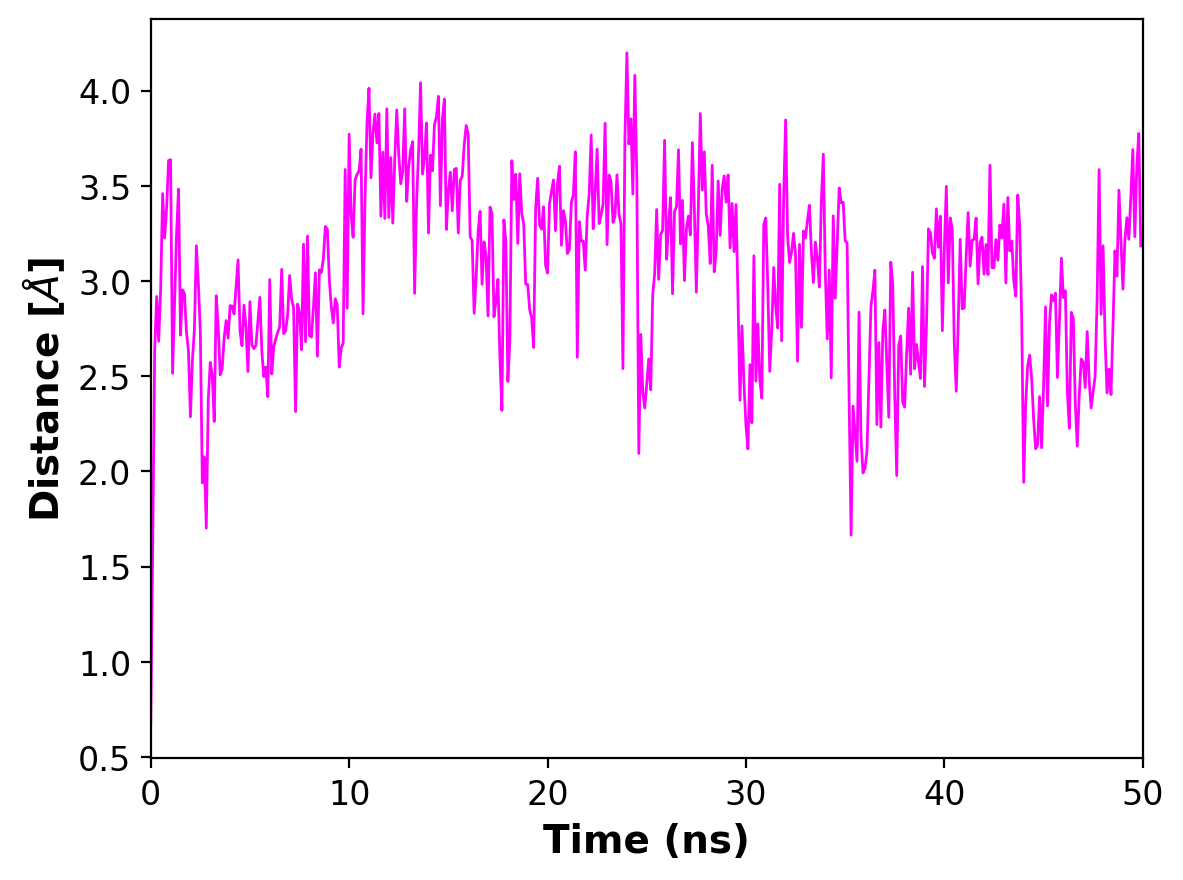

In [ ]:
#@title **Compute distance between the ligand and specific residues**
#@markdown **Provide output file names below:**
Output_name = 'distance_select' #@param {type:"string"}
#@markdown **Type the number of residues separated by commas and without spaces (1,2,3...):**
Residues = '69,77,81,86,87,94,95,98,180,254,255,258,324,329,407,411,412,413,414,415,455' #@param {type:"string"}

mask = ":LIG :" + str(Residues)
dist = pt.distance(traj_load, mask)
print("Selected residues = " + Residues + "\n")
dist_mean = mean(dist)
dist_stdev = stdev(dist)
print("Distance Average = " + str("{:.2f}".format(dist_mean)) + " \u00B1 " + str("{:.2f}".format(dist_stdev)) + " Å")

time = len(dist)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, dist, alpha=1, color = 'magenta', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Distance [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(dist)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

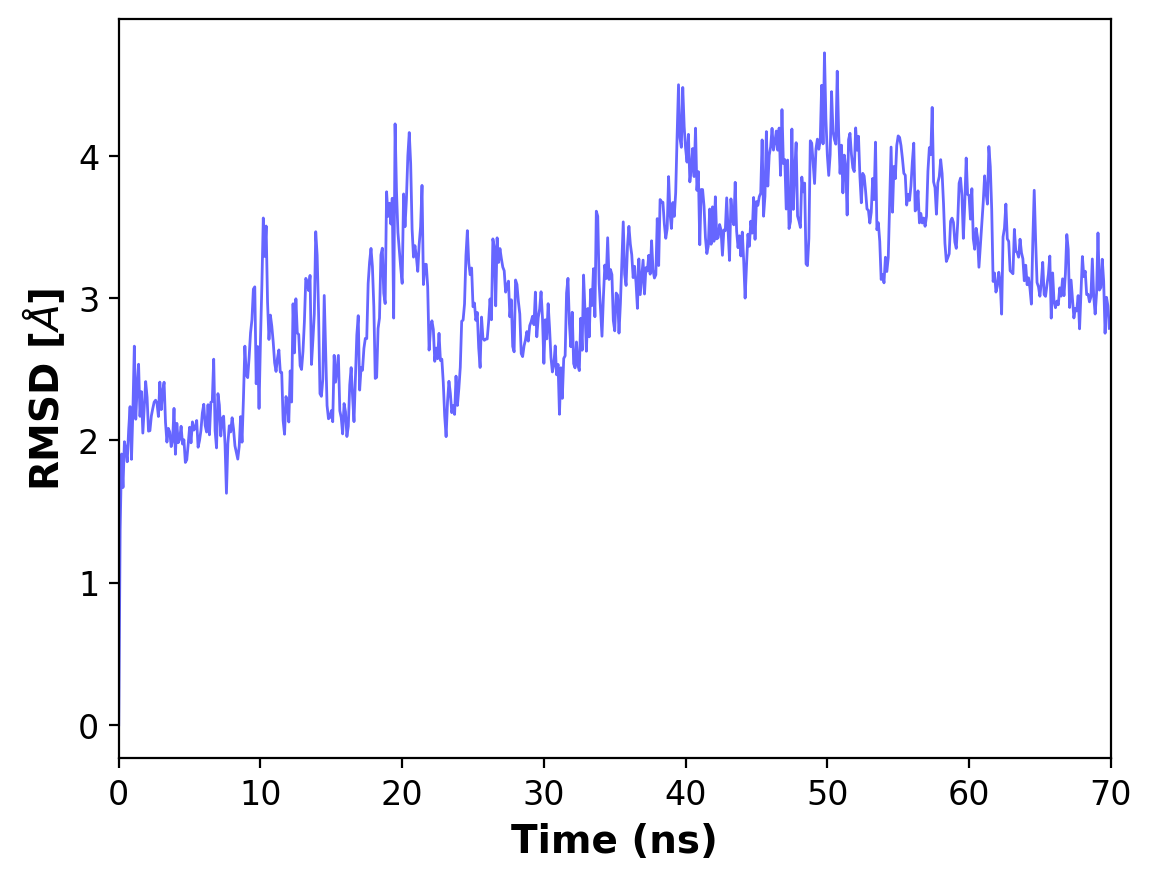

In [ ]:
#@title **Compute RMSD of protein's CA atoms**
#@markdown **Provide output file names below:**
Output_name = 'comp3_rmsd_ca' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
ax = plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

<ipython-input-36-832103e48785>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)


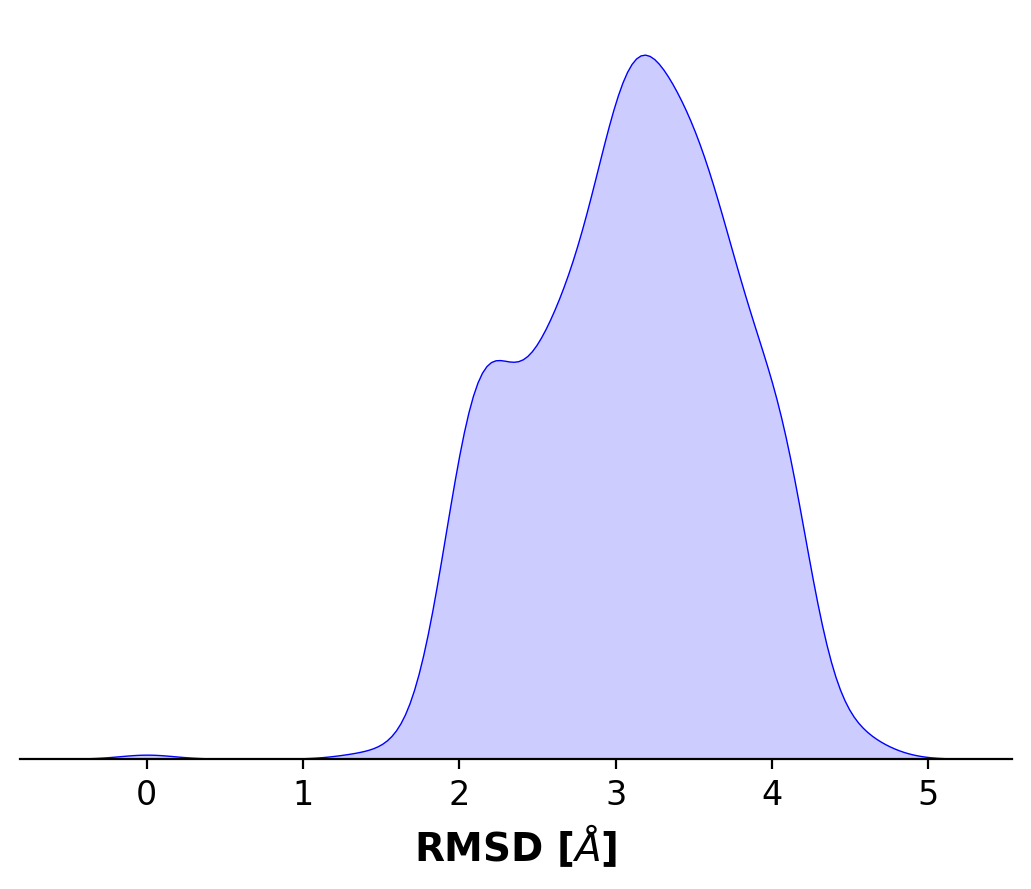

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'comp3_rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

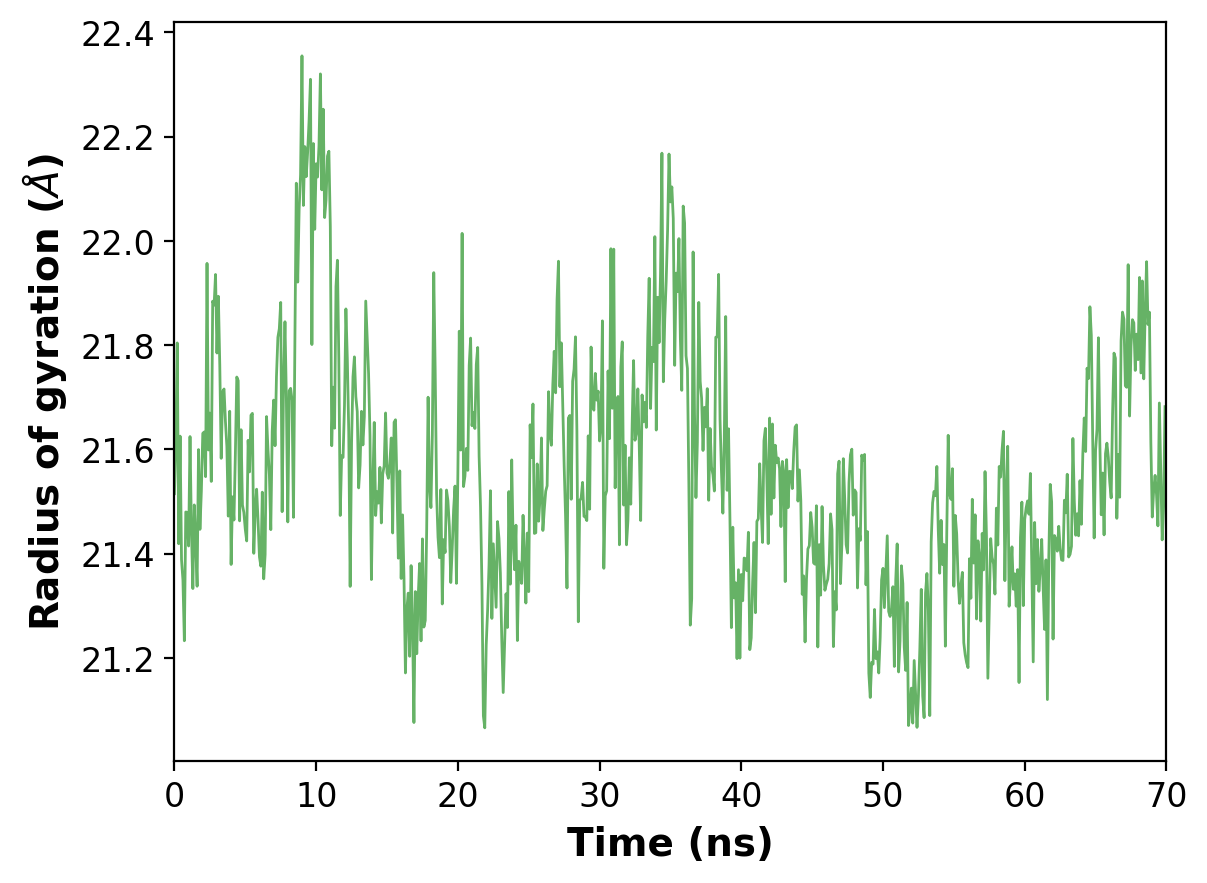

In [ ]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'comp3_radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)*int(stride_traj)

# Plotting:
plt.plot(time_array, radgyr, alpha=0.6, color = 'green', linewidth = 1.0)
plt.xlim(0, simulation_ns)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

<ipython-input-38-ce8bea862e71>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)


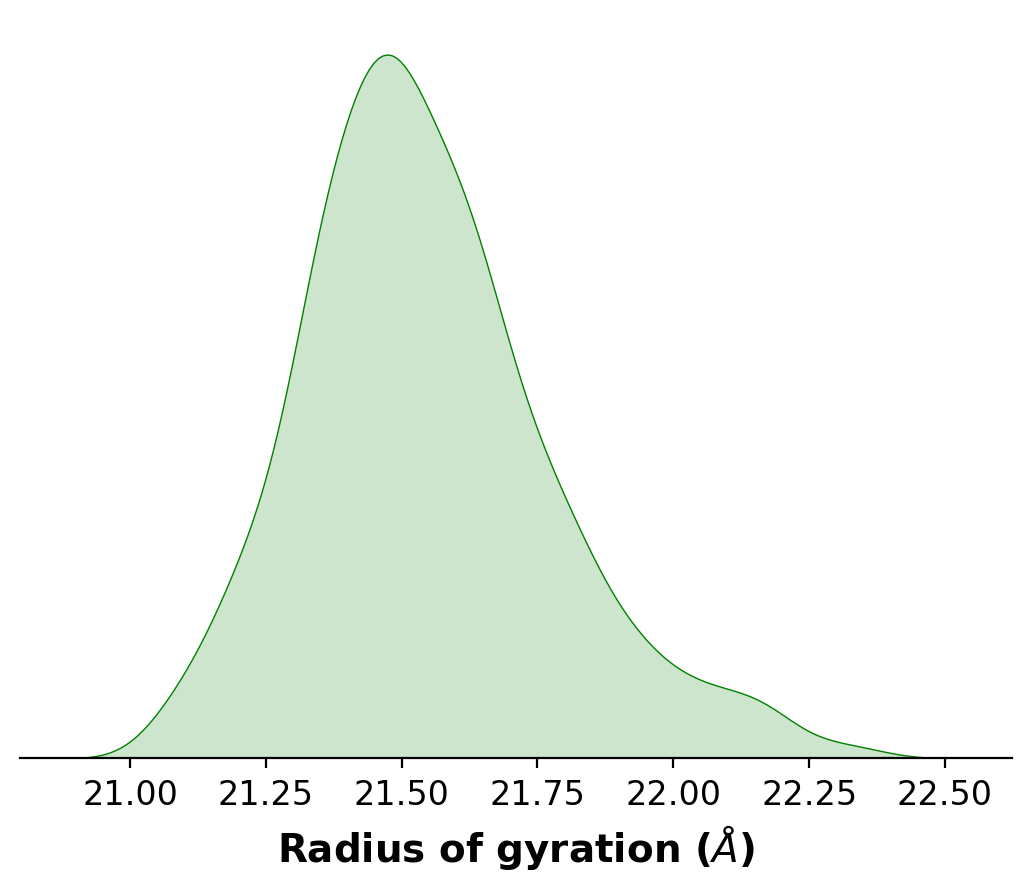

In [ ]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:**
Output_name = 'comp3_radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

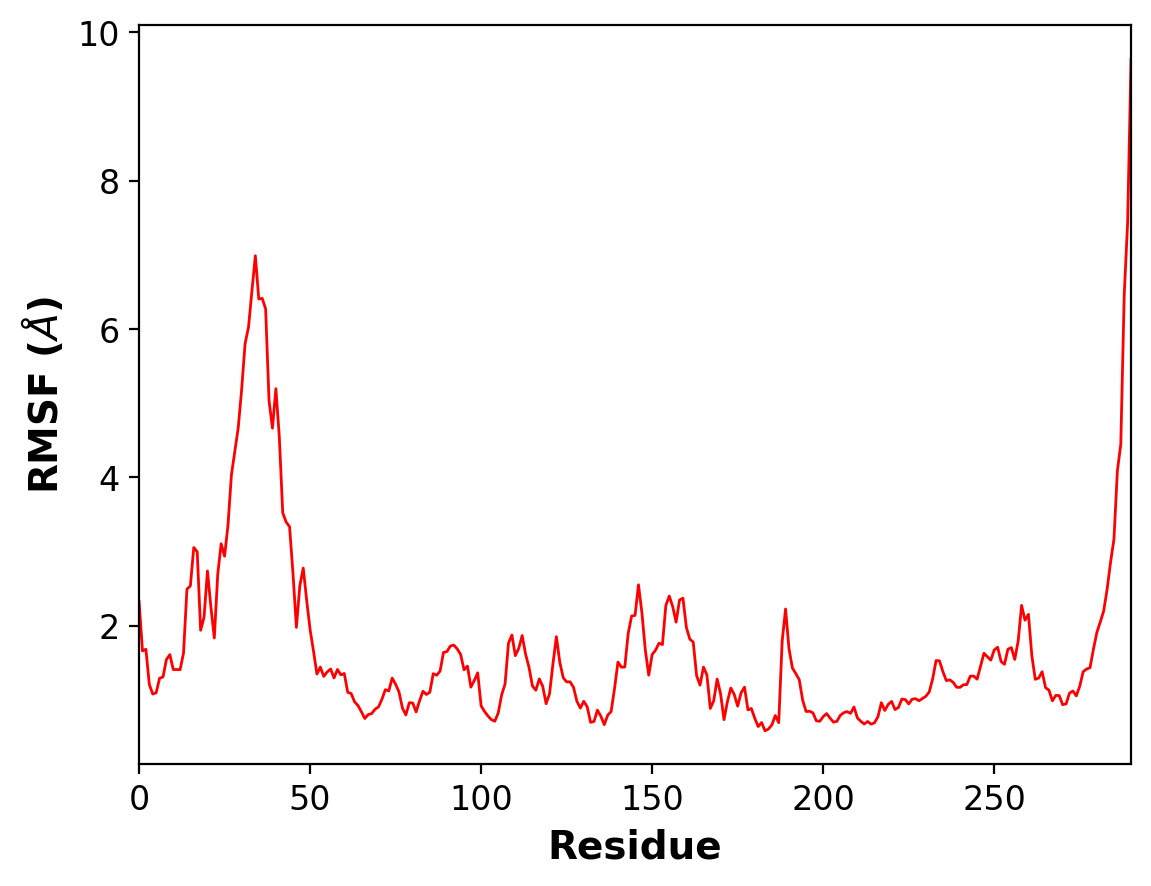

In [ ]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:**
Output_name = 'comp3_rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0)

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.xlim(0, len(rmsf[:-1]))

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

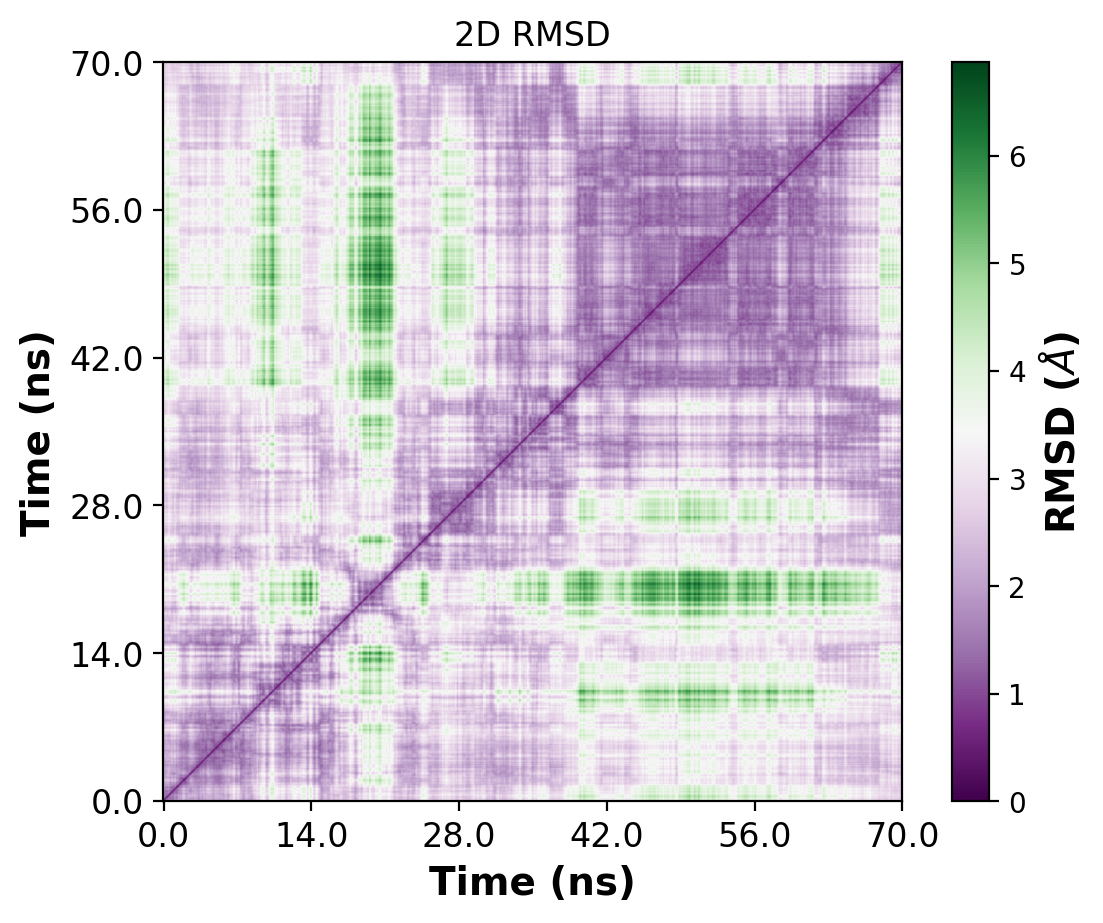

In [ ]:
#@title **2D RMSD**

#@markdown **Provide output file names below:**
Output_name = 'comp3_2D_rmsd' #@param {type:"string"}

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

mat1 = pt.pairwise_rmsd(traj_load, mask="@CA", frame_indices=range(int(number_frames_analysis)))


ax = plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title('2D RMSD')
plt.xlabel('Time (ns)', fontsize = 14, fontweight = 'bold')
plt.ylabel('Time (ns)', fontsize = 14, fontweight = 'bold')
# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
plt.xticks(a, b.round(decimals=3), fontsize = 12)
plt.yticks(a, b.round(decimals=3), fontsize = 12)
# plt.xlim(0, a[-1])
# plt.ylim(0, a[-1])

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat1)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

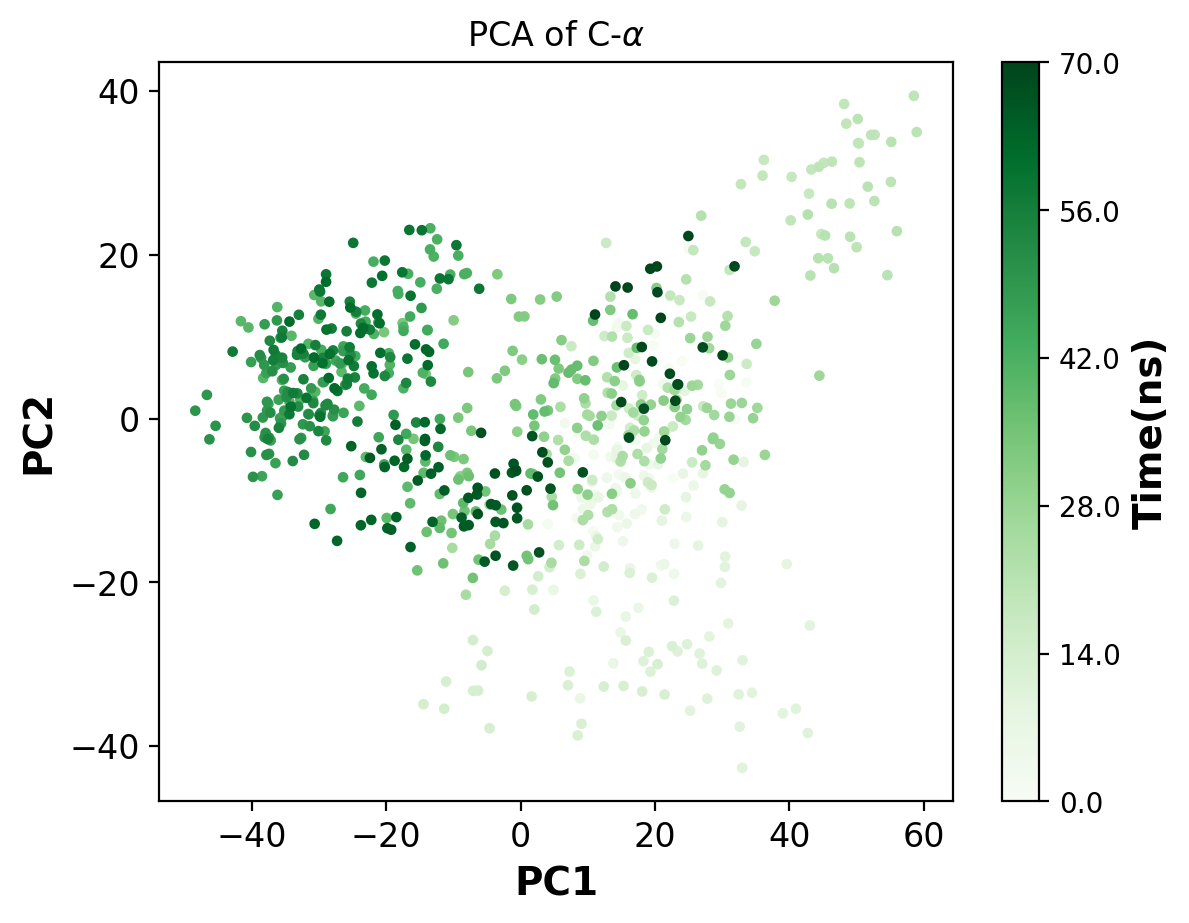

In [ ]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask='@CA', n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])

last_frame = len(time_array)

stride_ticks_f = (last_frame)/5
ticks_frame = np.arange(0,(len(time_array) + float(stride_ticks_f)), float(stride_ticks_f))
a = ticks_frame.astype(float)
a2 = a.tolist()
stride_ticks_t = (simulation_ns)/5
tick_time = np.arange(0,(float(simulation_ns) + float(stride_ticks_t)), float(stride_ticks_t))
b = tick_time.astype(float)

#@markdown **Provide output file names below:**
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA of C-$\alpha$')
PC1 = data[0][0]
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames_analysis)), cmap='Greens', marker='o',s=8, alpha=1)
plt.clim(0, last_frame)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# N = len(number_frames)
# x2 = np.arange(N)

cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Time(ns)', fontsize = 14, fontweight = 'bold')
cbar1.set_ticks(a2)
cbar1.set_ticklabels(b.round(decimals=3))

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

<ipython-input-42-4d4b4ae07cf2>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
<ipython-input-42-4d4b4ae07cf2>:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)


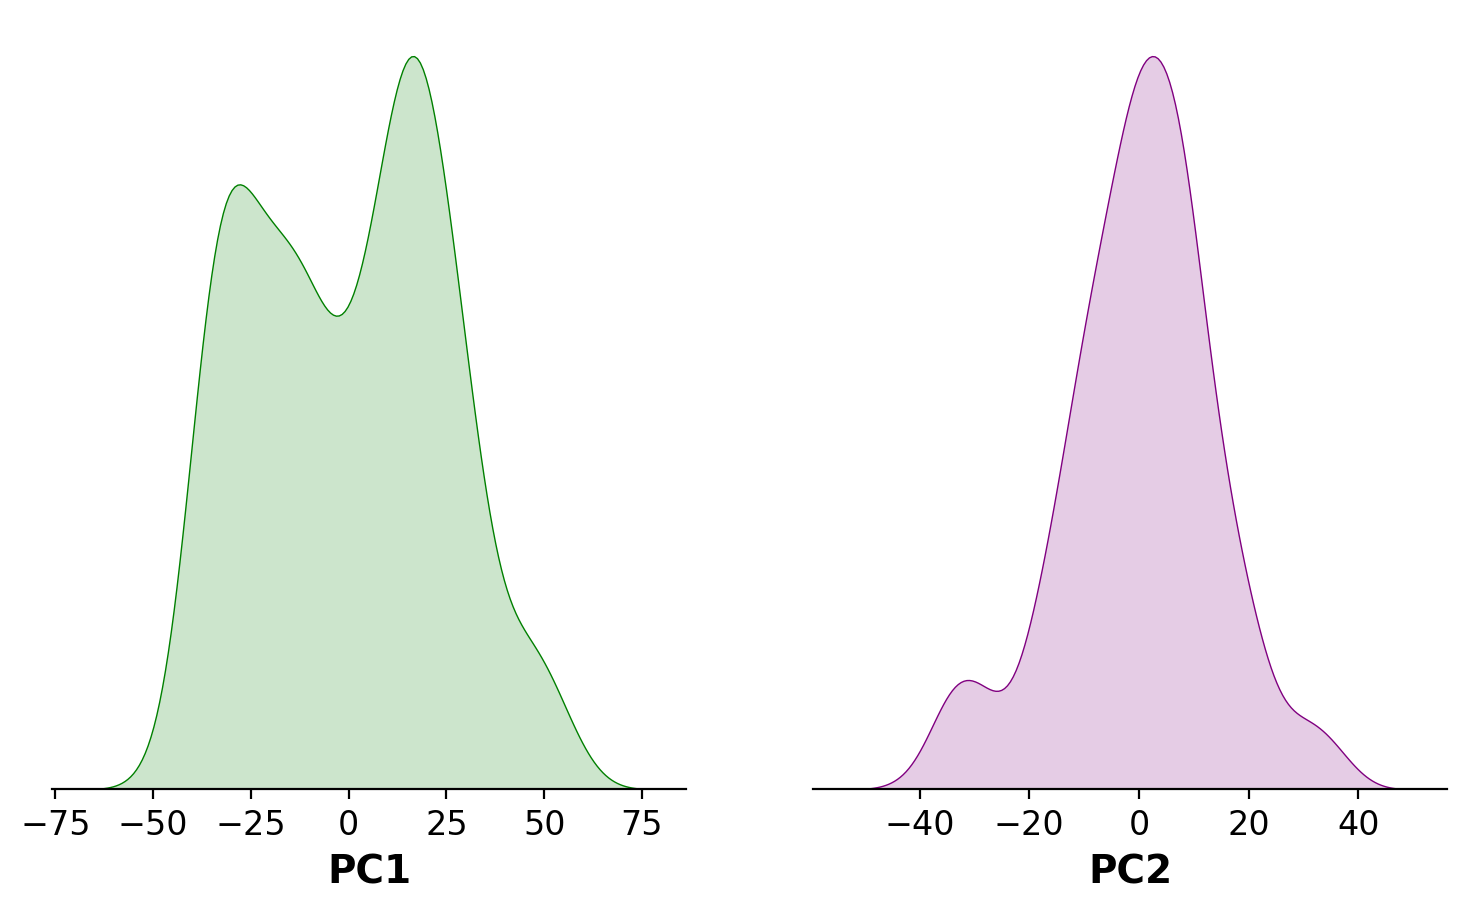

In [ ]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

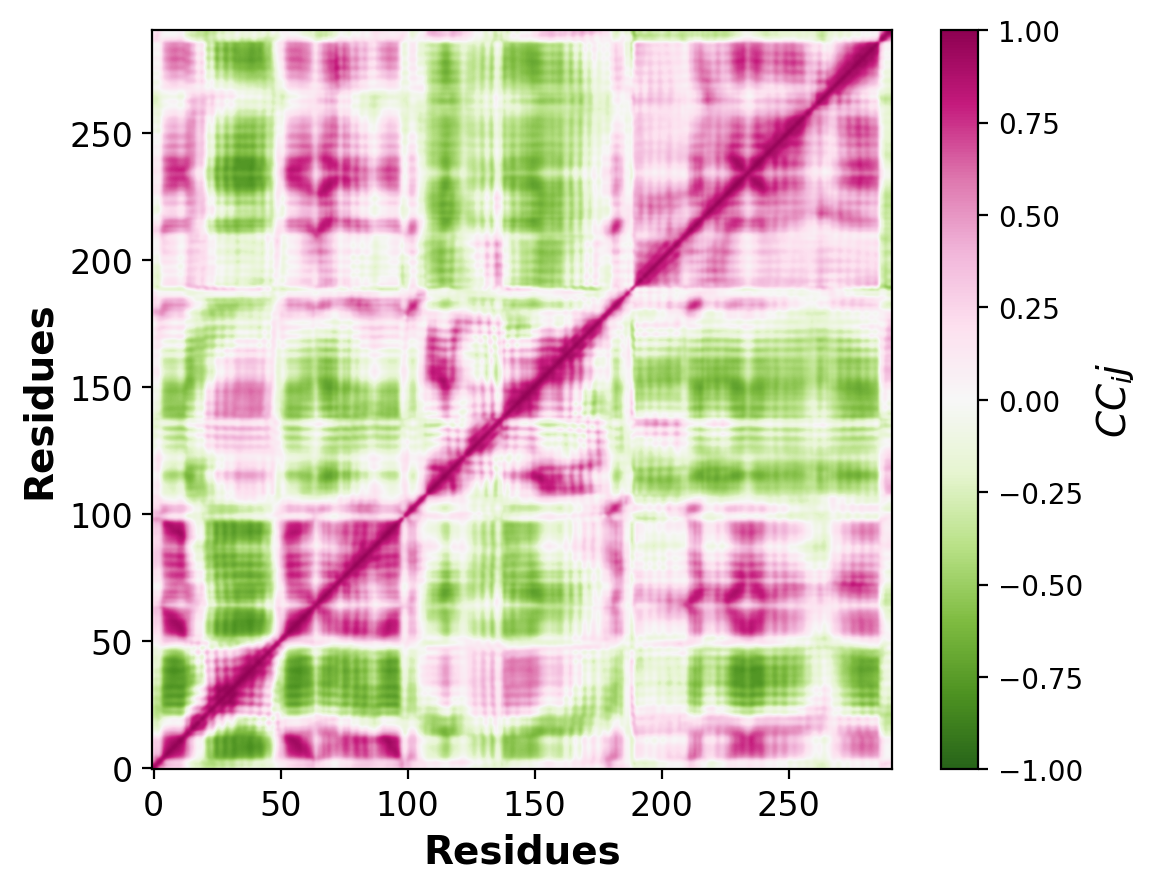

In [ ]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:**
Output_name = 'comp3_cross_correlation' #@param {type:"string"}


traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))